# Concept Network Tool

It is recommended to run all code chunks in order.

## Import data

Here user has to define the following:

- `DATA_PATH`: the folder including data files
- `DATA_FILES` : automatically detected `csv` files from `DATA_PATH` 


In [21]:
# Load R packages
pacman::p_load(tidyverse, udpipe, stopwords, igraph, ggraph, textrank, textreuse, patchwork, kableExtra)

In [22]:
DATA_PATH <- "processed_data"
DATA_FILES <- list.files(DATA_PATH, pattern = ".csv",full.names = TRUE,)

cat("Available datasets in", DATA_PATH, "\n",
    
    paste(paste(1:length(DATA_FILES) ,"\t", DATA_FILES, "\n"), sep = "\n"), "\n")


df_path <- DATA_FILES[as.numeric(readline(prompt="Select data: "))]
df_raw <- read.csv(df_path)

cat(df_path, "selected.")

Available datasets in processed_data 
 1 	 processed_data/hs2014_processed.csv 
 2 	 processed_data/techeldercare_Q59_processed.csv 
 3 	 processed_data/techeldercare_Q62_processed.csv 
 
processed_data/hs2014_processed.csv selected.

## Stopword removal

R package [`stopwords`](https://cran.r-project.org/web/packages/stopwords/readme/README.html) includes three Finnish stop word lists: 

    1. nltk
    2. snowball
    3. stopwords-iso


Then filter the data by excluding words from the stop word list.

In [36]:
sw_lists_available <- sort(stopwords_getsources()[unlist(lapply(stopwords_getsources(), function(x) ifelse("fi" %in% stopwords_getlanguages(x), TRUE, FALSE)))])
sw_lists <- c(lapply(sw_lists_available, function(y) stopwords("fi", y)), list(NA))
sw_list_sizes <- lapply(sw_lists, function(z) ifelse(length(z) > 1, length(z), 0))
                
sw_options <- c(paste(c(sw_lists_available, "None"), paste0("(", sw_list_sizes, " words)")), "Custom")
                        
cat("Stopword lists available:\n",paste(paste(1:length(sw_options) ,"\t", sw_options, "\n"), sep = "\n"), "\n")

sw_selection <- readline(prompt="Select stopword list: ")                        

if(as.numeric(sw_selection) == length(sw_options)) {
    custom_stopwords <- readline(prompt="List all stopwords. Separate with a comma.\n")
    stopword_list <- trimws(stringr::str_split(custom_stopwords, ",", simplify = TRUE), "both")
    cat(length(stopword_list), "stopwords saved.")
} else {
    stopword_list <- sw_lists[[as.numeric(sw_selection)]]
    cat("Stopwords:\n", paste(stopword_list, collapse = ", "), sep ="")
}

# Remove all the stop words above from the data
df <- df_raw %>%
    mutate(lemma = str_replace(lemma, "#", "")) %>%
    filter(!lemma %in% stopword_list) 
       
# Vocabulary       
vocab <- unique(df$lemma)                      

Stopword lists available:
 1 	 nltk (229 words) 
 2 	 snowball (68 words) 
 3 	 stopwords-iso (847 words) 
 4 	 None (0 words) 
 5 	 Custom 
 
Stopwords:
olla, olen, olet, on, olemme, olette, ovat, ole, oli, olisi, olisit, olisin, olisimme, olisitte, olisivat, olit, olin, olimme, olitte, olivat, ollut, olleet, en, et, ei, emme, ette, eivät, minä, sinä, hän, me, te, he, tämä, tuo, se, nämä, nuo, ne, kuka, ketkä, mikä, mitkä, joka, jotka, että, ja, jos, koska, kuin, mutta, niin, sekä, sillä, tai, vaan, vai, vaikka, kanssa, mukaan, noin, poikki, yli, kun, niin, nyt, itse

# Options

In [24]:
# seed number, used for network plot layouts
seed_num <- 2022

# relevant words by part of speech
relevant_pos <- c("NOUN", "VERB", "ADJ")

# minimum number of occurences
min_occurences <- 5

# Data summary


In [25]:
words_table <-  df %>%
    summarize(respondents = n_distinct(doc_id),
        total_tokens = n(),
        unique_words = length(unique(token)),
        unique_lemmas = length(unique(lemma))) 


pos_table <-  df %>% 
    count(upos, sort = TRUE) %>%
    pivot_wider(names_from = upos, values_from = n, values_fill = 0)


words_table
pos_table


respondents,total_tokens,unique_words,unique_lemmas
<int>,<int>,<int>,<int>
3485,77732,17744,7780


NOUN,PUNCT,VERB,ADV,ADJ,PRON,ADP,AUX,NUM,PROPN,SYM,CCONJ,SCONJ,INTJ,X
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
20972,16321,14912,10276,9016,3371,1001,911,406,232,76,71,71,49,47


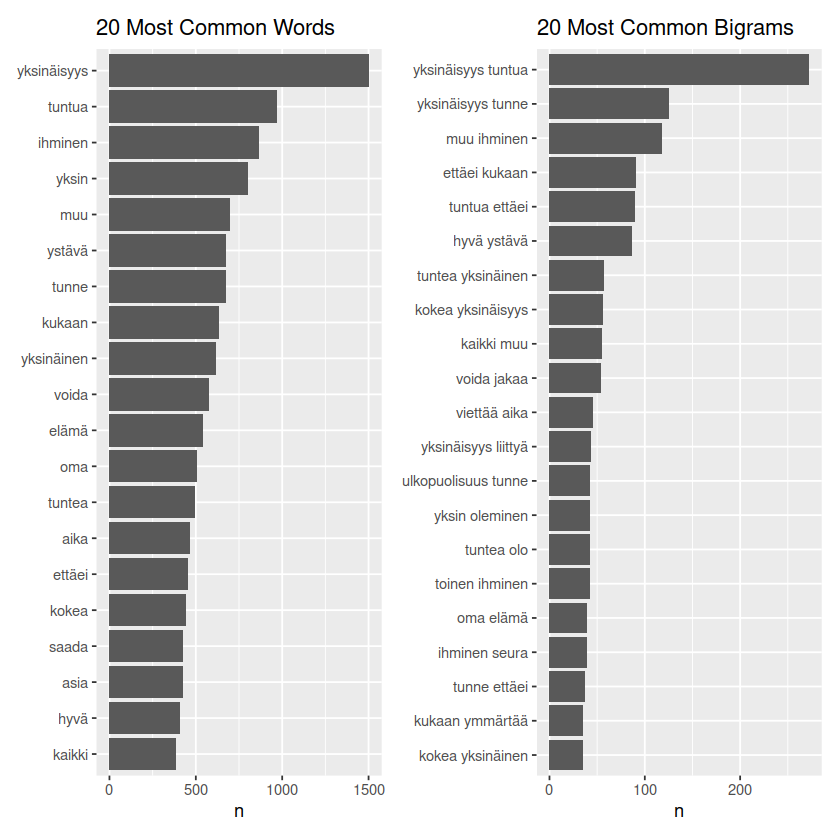

In [37]:
word_freqs <- df %>% 
  filter(dep_rel != "punct") %>%
  count(lemma, sort = TRUE) %>%
  slice_max(n, n = 20) %>%
  mutate(lemma = reorder(lemma, n)) %>%
  ggplot(aes(n, lemma)) +
  geom_col() +
  labs(y = NULL, title = "20 Most Common Words")

bigram_freqs <- df %>%
  filter(dep_rel != "punct") %>%
   mutate(bigram = txt_nextgram(lemma, n = 2)) %>%
  count(bigram, sort = TRUE) %>%
  slice_max(n, n = 20) %>%
  mutate(bigram = reorder(bigram, n)) %>%
  ggplot(aes(n, bigram)) +
  geom_col() +
  labs(y = NULL, title = "20 Most Common Bigrams")

  word_freqs + bigram_freqs

## Word Coccurences in context

Warning message:
“ggrepel: 275 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


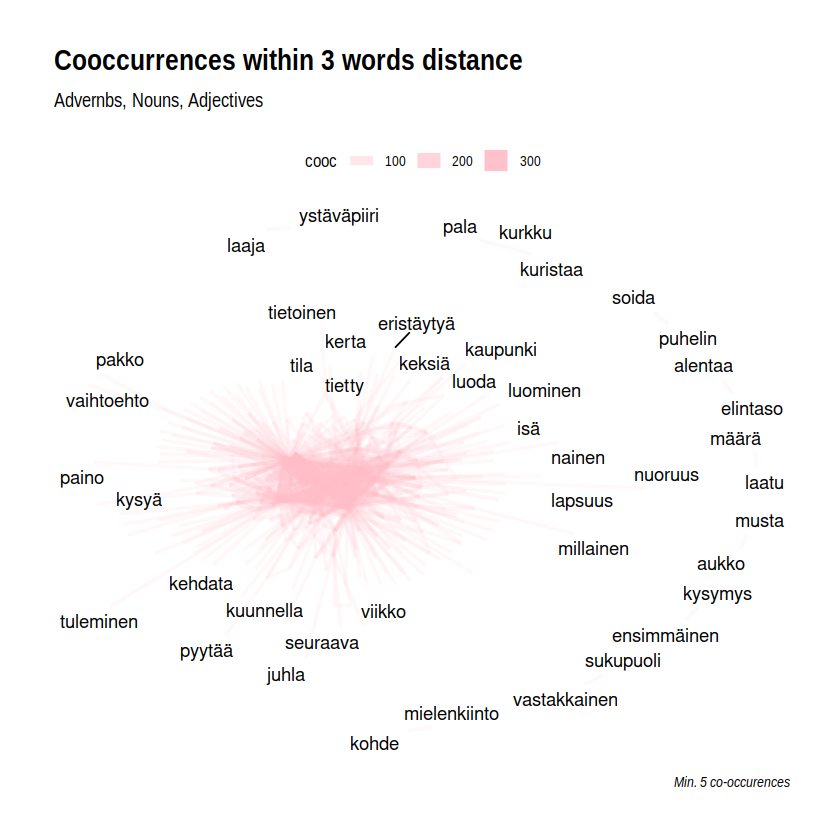

In [27]:
set.seed(seed_num)

cooc_context <- cooccurrence(x = df$lemma, 
                     relevant = df$upos %in% relevant_pos, 
                      skipgram = 2)

subset(cooc_context, cooc >= min_occurences) %>%
graph_from_data_frame() %>%
ggraph(layout = "fr") +
  geom_edge_link(aes(width = cooc, edge_alpha = cooc), edge_colour = "pink") +
  geom_node_text(aes(label = name), repel = TRUE) +
  theme_graph() +
  theme(legend.position = "top") +
  labs(title = "Cooccurrences within 3 words distance", 
       subtitle = "Advernbs, Nouns, Adjectives",
       caption = paste("Min.", min_occurences, "co-occurences"))

# Functions

In [30]:
find_concepts <- function(data, concept) {
    
    if(str_detect(concept, ",")){
        concept <- str_extract_all(concept, pattern = "\\w+") %>% 
        unlist()
        
        cat("Displaying results including following concepts:", "\n",
            paste(paste(1:length(concept) ,"\t", concept, "\n"), sep = "\n"), "\n")
    }
    
    concept_keywords <- data %>% 
        filter(word1 %in% concept)  %>%
        pull(keyword)
    
    all_concepts <- data %>% 
        filter(keyword %in% concept_keywords)
    
    return(all_concepts)
}

get_edges <- function(data, concept, threshold = NULL) {
    df <-  data %>%
    find_concepts(concept = concept) %>%
    select(word1, word2, freq) %>%
    group_by(word1,word2) %>%
    summarize(n = sum(freq), .groups = "drop") %>%
    rename(from = word1,
          to = word2)
    
    if(!is.null(threshold)) {
        df <- df %>% filter(n >= threshold)
    }
    
    return(df)
} 

get_nodes <- function(data, vocab) {
    df <- data %>% filter(lemma %in% vocab)
    
    return(df)
}

plot_graph <- function(edges, nodes, concepts, ...) {  
    
nodes <- nodes %>%
    mutate(is_concept = factor(ifelse(lemma %in% concepts, 0, 1), levels = 0:1, labels = c("Concept word", "Regular word")))

p <- graph_from_data_frame(edges, directed = FALSE, vertices = nodes) %>%
    ggraph(layout = "kk") +
    geom_edge_link(aes(width = n, edge_alpha = n), edge_colour = "lightblue") +
    geom_node_point(aes(size = pagerank)) +
    geom_node_text(aes(label = name, col = is_concept), check_overlap = TRUE, repel = TRUE) +
    scale_color_manual("", values = c("Concept word" = "red", "Regular word" = "black")) +
    theme_graph() +
    labs(
        title = "Textrank extracted keyword occurences",
        subtitle = "Adjectives, Nouns, Verbs",
         ... ) +
    theme(legend.position = "right")    

return(p)
}

textrank_graph <- function(x, input_word, relevant, threshold) {
    keyw <- textrank_keywords(x ,
                            relevant = df$upos %in% relevant )

    keyword_data <- keyw$keywords %>% 
        filter(ngram > 1 & freq > 1) %>% 
        mutate(word2 = strsplit(keyword, "-")) %>% 
        unnest(word2) %>%
        group_by(keyword) %>%
        mutate(word1 = lag(word2)) %>%
        relocate(word1, .before = word2) %>%
        ungroup() %>%
        filter(!is.na(word1))


    textrank_data <- data.frame(pagerank = keyw$pagerank$vector) %>%
        rownames_to_column("lemma") 


    edges <- get_edges(keyword_data, concept = input_word, threshold = threshold)
    keyword_vocab <- unique(c(edges$from, edges$to))
    nodes <- get_nodes(textrank_data, vocab = keyword_vocab)    
    plot_graph(edges, nodes, concepts = query_list, caption = paste("Min.", threshold, "occurences."))
}


# Concept extraction

Input words that represent the question.

In [29]:
query <- tolower(readline(prompt="Enter words (separated by a comma):"))

query_list <- str_extract_all(query, pattern = "\\w+") %>% unlist()

set.seed(seed_num)

while(TRUE) {
   valid_words = query_list %in% vocab
    
    if(tolower(query) == "c"){
        interactive_status <- FALSE
        cat("Stopping.")
        break
    }
    

    
    if(any(valid_words != TRUE)){
        
        cat("Following words not found in vocabulary:", paste(query_list[!valid_words], collapse = ", "), "\n")
        flush.console()
        
        query <- tolower(readline(prompt="Re-enter words: (or C to stop)"))
        query_list <- str_extract_all(query, pattern = "\\w+") %>% unlist()
        
    } 
    
    if(all(valid_words) == TRUE){
        interactive_status <- TRUE
        found_data = df %>% filter(lemma %in% query_list)
        break
    }

   
}

# Keyword extractions

## Textrank

Displaying results including following concepts: 
 1 	 yksinäisyys 
 2 	 tunne 
 


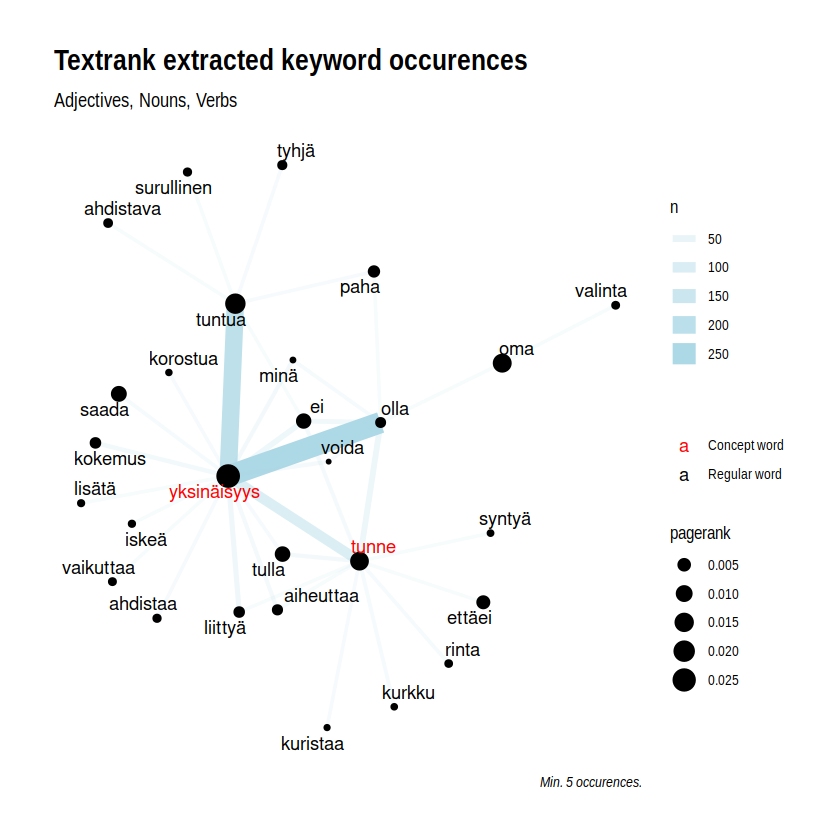

In [35]:
textrank_graph(df$lemma, input_word = query, relevant = relevant_pos, threshold = min_occurences)

## Likey